In [ ]:
!wget -q --show-progress https://github.com/RecoHut-Datasets/movielens_1m/raw/v3/ml1m.csv
!unzip ml1m.zip

ml1m.csv            100%[===================>]  13.75M  --.-KB/s    in 0.1s    
unzip:  cannot find or open ml1m.zip, ml1m.zip.zip or ml1m.zip.ZIP.


In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, Concatenate, Dot, Lambda
from keras.optimizers import Adam
from keras import backend as K

from sklearn.metrics import precision_score, recall_score, ndcg_score, mean_absolute_error, mean_squared_error, r2_score

In [ ]:
dataset = 'ml1m'
latent_dim = 5
like_threshold = 4
steps_per_epoch = None

deepmf_epochs = 10
ncf_epochs = 10
neumf_epochs = 10
vdeepmf_epochs = 6
vncf_epochs = 9
vneumf_epochs = 5

In [ ]:
df = pd.read_csv('/content/ml1m.csv', delimiter = ',')

num_users = df.user.max() + 1
num_items = df.item.max() + 1

X = df[['user', 'item']].to_numpy()
y = df[['rating']].to_numpy()


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = [X_train[:,0], X_train[:,1]]
X_test = [X_test[:,0], X_test[:,1]]

In [ ]:
X_train

[array([3020, 4656,   20, ..., 1084, 4604, 1013]),
 array([1064, 1349, 2402, ..., 2011,  196, 1149])]

DEEPMF


In [ ]:
user_input = Input(shape=[1])
user_embedding = Embedding(num_users, latent_dim)(user_input)
user_vec = Flatten()(user_embedding)

item_input = Input(shape=[1])
item_embedding = Embedding(num_items, latent_dim)(item_input)
item_vec = Flatten()(item_embedding)

dot = Dot(axes=1)([item_vec, user_vec])

DeepMF = Model([user_input, item_input], dot)

In [ ]:
with tf.device('/GPU:1'):
    DeepMF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
    DeepMF.summary()

    deepmf_report = DeepMF.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=deepmf_epochs, steps_per_epoch=steps_per_epoch, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 5)           │         18,530 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 5)           │         30,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 5)              │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 5)              │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 1)              │              0 │ flatten_1[0][0],       │
│                           │                        │                │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 48,730 (190.35 KB)

 Trainable params: 48,730 (190.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 8.5362 - mae: 2.5103 - val_loss: 1.0504 - val_mae: 0.7973
Epoch 2/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - loss: 0.9597 - mae: 0.7666 - val_loss: 0.8846 - val_mae: 0.7406
Epoch 3/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.8700 - mae: 0.7348 - val_loss: 0.8672 - val_mae: 0.7335
Epoch 4/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 0.8507 - mae: 0.7265 - val_loss: 0.8495 - val_mae: 0.7261
Epoch 5/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 0.8292 - mae: 0.7165 - val_loss: 0.8328 - val_mae: 0.7175
Epoch 6/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 87s 2ms/step - loss: 0.8091 - mae: 0.7064 - val_loss: 0.8171 - val_mae: 0.7112
Epoch 7/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 0.7916 - mae: 0.6978 - val_loss: 0.8088 - val_mae: 0.7056
Epoch 8/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.7751 - mae: 0.6897 - val_loss: 0.8044 - val_mae: 0.7035
Epoch 9/10
25006

NCF


In [ ]:
item_input = Input(shape=[1], name='item-input')
item_embedding = Embedding(num_items, latent_dim, name='item-embedding')(item_input)
item_vec = Flatten(name='item-flatten')(item_embedding)

user_input = Input(shape=[1], name='user-input')
user_embedding = Embedding(num_users, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

concat = Concatenate(axis=1, name='item-user-concat')([item_vec, user_vec])
fc_1 = Dense(70, name='fc-1', activation='relu')(concat)
fc_1_dropout = Dropout(0.5, name='fc-1-dropout')(fc_1)
fc_2 = Dense(30, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.4, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)

NCF = Model([user_input, item_input], fc_3)

In [ ]:
with tf.device('/GPU:1'):
    NCF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
    NCF.summary()

    ncf_report = NCF.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=ncf_epochs, steps_per_epoch=steps_per_epoch, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ item-input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user-input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item-embedding            │ (None, 1, 5)           │         18,530 │ item-input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user-embedding            │ (None, 1, 5)           │         30,200 │ user-input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item-flatten (Flatten)    │ (None, 5)              │              0 │ item-embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user-flatten (Flatten)    │ (None, 5)              │              0 │ user-embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item-user-concat          │ (None, 10)             │              0 │ item-flatten[0][0],    │
│ (Concatenate)             │                        │                │ user-flatten[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-1 (Dense)              │ (None, 70)             │            770 │ item-user-concat[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-1-dropout (Dropout)    │ (None, 70)             │              0 │ fc-1[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-2 (Dense)              │ (None, 30)             │          2,130 │ fc-1-dropout[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-2-dropout (Dropout)    │ (None, 30)             │              0 │ fc-2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-3 (Dense)              │ (None, 1)              │             31 │ fc-2-dropout[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,661 (201.80 KB)

 Trainable params: 51,661 (201.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 1.4255 - mae: 0.9271 - val_loss: 0.8591 - val_mae: 0.7285
Epoch 2/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - loss: 0.8453 - mae: 0.7277 - val_loss: 0.8323 - val_mae: 0.7205
Epoch 3/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - loss: 0.8235 - mae: 0.7158 - val_loss: 0.8086 - val_mae: 0.7073
Epoch 4/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - loss: 0.8103 - mae: 0.7089 - val_loss: 0.8078 - val_mae: 0.7095
Epoch 5/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - loss: 0.7989 - mae: 0.7030 - val_loss: 0.7925 - val_mae: 0.7028
Epoch 6/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 0.7910 - mae: 0.6992 - val_loss: 0.7881 - val_mae: 0.6976
Epoch 7/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - loss: 0.7900 - mae: 0.6987 - val_loss: 0.7853 - val_mae: 0.6997
Epoch 8/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 0.7845 - mae: 0.6956 - val_loss: 0.7848 - val_mae: 0.6957
Epoch 9/10
25006

VDEEPMF


In [ ]:
batch_size = 32
latent_dim = 13  # Example latent dimension

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda, Flatten, Dropout, Dot
from tensorflow.keras.models import Model

def sampling(args):
    z_mean, z_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_var) * epsilon  # Scaled variance for stability

# User Input
user_input = Input(shape=[1])
user_embedding = Embedding(num_users, latent_dim, embeddings_initializer='random_uniform')(user_input)
user_embedding_mean = Dense(latent_dim)(user_embedding)
user_embedding_var = Dense(latent_dim)(user_embedding)
user_embedding_z = Lambda(sampling, output_shape=(latent_dim,))([user_embedding_mean, user_embedding_var])
user_vec = Flatten()(user_embedding_z)

# Item Input
item_input = Input(shape=[1])
item_embedding = Embedding(num_items, latent_dim, embeddings_initializer='random_uniform')(item_input)
item_embedding_mean = Dense(latent_dim)(item_embedding)
item_embedding_var = Dense(latent_dim)(item_embedding)
item_embedding_z = Lambda(sampling, output_shape=(latent_dim,))([item_embedding_mean, item_embedding_var])
item_vec = Flatten()(item_embedding_z)

# Dot Product
dot = Dot(axes=1)([item_vec, user_vec])

# Model
VDeepMF = Model([user_input, item_input], dot)



In [ ]:
with tf.device('/GPU:1'):
    VDeepMF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
    VDeepMF.summary()

    vdeepmf_report = VDeepMF.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=vdeepmf_epochs, batch_size=batch_size, steps_per_epoch=steps_per_epoch, verbose=1)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1, 13)          │         48,178 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 13)          │         78,520 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 13)          │            182 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 13)          │            182 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 13)          │            182 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 13)          │            182 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 13)             │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 13)             │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 13)             │              0 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 13)             │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_1 (Dot)               │ (None, 1)              │              0 │ flatten_3[0][0],       │
│                           │                        │                │ flatten_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 127,426 (497.76 KB)

 Trainable params: 127,426 (497.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 104s 4ms/step - loss: 5.6984 - mae: 1.5992 - val_loss: 0.8269 - val_mae: 0.7218
Epoch 2/6
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 148s 4ms/step - loss: 0.8014 - mae: 0.7057 - val_loss: 0.7810 - val_mae: 0.6935
Epoch 3/6
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - loss: 0.7454 - mae: 0.6777 - val_loss: 0.7621 - val_mae: 0.6872
Epoch 4/6
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - loss: 0.7114 - mae: 0.6602 - val_loss: 0.7535 - val_mae: 0.6840
Epoch 5/6
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 148s 4ms/step - loss: 0.6856 - mae: 0.6462 - val_loss: 0.7520 - val_mae: 0.6810
Epoch 6/6
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 104s 4ms/step - loss: 0.6660 - mae: 0.6359 - val_loss: 0.7486 - val_mae: 0.6742


VNCF

In [ ]:
batch_size = 32
latent_dim = 13  # Example latent dimension

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda, Flatten, Dropout, Dot
from tensorflow.keras.models import Model

def sampling(args):
    z_mean, z_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_var) * epsilon  # Scaled variance for stability

# User Input
user_input = Input(shape=[1])
user_embedding = Embedding(num_users, latent_dim, embeddings_initializer='random_uniform')(user_input)
user_embedding_mean = Dense(latent_dim)(user_embedding)
user_embedding_var = Dense(latent_dim)(user_embedding)
user_embedding_z = Lambda(sampling, output_shape=(latent_dim,))([user_embedding_mean, user_embedding_var])
user_vec = Flatten()(user_embedding_z)

# Item Input
item_input = Input(shape=[1])
item_embedding = Embedding(num_items + 1, latent_dim, embeddings_initializer='random_uniform')(item_input)
item_embedding_mean = Dense(latent_dim)(item_embedding)
item_embedding_var = Dense(latent_dim)(item_embedding)
item_embedding_z = Lambda(sampling, output_shape=(latent_dim,))([item_embedding_mean, item_embedding_var])
item_vec = Flatten()(item_embedding_z)

concat = Concatenate(axis=1)([item_vec, user_vec])

fc_1 = Dense(80, name='fc-1', activation='relu')(concat)
fc_1_dropout = Dropout(0.6, name='fc-1-dropout')(fc_1)
fc_2 = Dense(25, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.4, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)

VNCF = Model([user_input, item_input], fc_3)

In [ ]:
with tf.device('/GPU:1'):
    VNCF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
    VNCF.summary()

    vncf_report = VNCF.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=vncf_epochs, batch_size=batch_size, steps_per_epoch=steps_per_epoch, verbose=1)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 1, 13)          │         48,191 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 1, 13)          │         78,520 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1, 13)          │            182 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1, 13)          │            182 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 13)          │            182 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1, 13)          │            182 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 13)             │              0 │ dense_6[0][0],         │
│                           │                        │                │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 13)             │              0 │ dense_4[0][0],         │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 13)             │              0 │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 13)             │              0 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 26)             │              0 │ flatten_5[0][0],       │
│                           │                        │                │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-1 (Dense)              │ (None, 80)             │          2,160 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-1-dropout (Dropout)    │ (None, 80)             │              0 │ fc-1[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-2 (Dense)              │ (None, 25)             │          2,025 │ fc-1-dropout[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-2-dropout (Dropout)    │ (None, 25)             │              0 │ fc-2[0][0]             │
├──────────────────────

 Total params: 131,650 (514.26 KB)

 Trainable params: 131,650 (514.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 126s 5ms/step - loss: 1.5851 - mae: 0.9832 - val_loss: 0.8887 - val_mae: 0.7410
Epoch 2/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 149s 5ms/step - loss: 0.8783 - mae: 0.7424 - val_loss: 0.8501 - val_mae: 0.7238
Epoch 3/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - loss: 0.8516 - mae: 0.7284 - val_loss: 0.8358 - val_mae: 0.7186
Epoch 4/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 125s 5ms/step - loss: 0.8365 - mae: 0.7211 - val_loss: 0.8267 - val_mae: 0.7133
Epoch 5/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 127s 5ms/step - loss: 0.8277 - mae: 0.7167 - val_loss: 0.8100 - val_mae: 0.7076
Epoch 6/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step - loss: 0.8189 - mae: 0.7132 - val_loss: 0.8034 - val_mae: 0.7030
Epoch 7/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step - loss: 0.8069 - mae: 0.7076 - val_loss: 0.8004 - val_mae: 0.7064
Epoch 8/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 131s 5ms/step - loss: 0.8018 - mae: 0.7044 - val_loss: 0.7939 - val_mae: 0.6971
Epoch 9/9
25006/

METRICS


In [ ]:
methods = ['vdeepmf', 'deepmf', 'vncf', 'ncf']

In [ ]:
preds = pd.DataFrame()

preds['user'] = X_test[0]
preds['item'] = X_test[1]

preds['y_test'] = y_test

In [ ]:
y_true = preds['y_test'].to_numpy()

In [ ]:
preds['deepmf'] = DeepMF.predict(X_test)

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


In [ ]:
preds['ncf'] = NCF.predict(X_test)

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


In [ ]:
n_repeats = 10

In [ ]:
predictions = None

for i in range(n_repeats):
    if i == 0:
        predictions = VDeepMF.predict(X_test)
    else:
        predictions = np.append(predictions, VDeepMF.predict(X_test), axis=1)

preds['vdeepmf'] = np.mean(predictions, axis=1)

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


In [ ]:
predictions = None

for i in range(n_repeats):
    if i == 0:
        predictions = VNCF.predict(X_test)
    else:
        predictions = np.append(predictions, VNCF.predict(X_test), axis=1)

preds['vncf'] = np.mean(predictions, axis=1)

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


Quality of predictions

In [ ]:
print('MAE:')
for m in methods:
    print('-', m, ':', mean_absolute_error(preds['y_test'], preds[m]))

print('MSD:')
for m in methods:
    print('-', m, ':', mean_squared_error(preds['y_test'], preds[m]))

print('R2:')
for m in methods:
    print('-', m, ':', r2_score(preds['y_test'], preds[m]))

MAE:
- vdeepmf : 0.6741069151942197
- deepmf : 0.7006746134682031
- vncf : 0.7024426644024406
- ncf : 0.7005118804289705
MSD:
- vdeepmf : 0.7483817978545956
- deepmf : 0.7985136907887443
- vncf : 0.7904682458566137
- ncf : 0.7912920981792179
R2:
- vdeepmf : 0.4016448235766875
- deepmf : 0.3615627722400042
- vncf : 0.36799536271129796
- ncf : 0.36733666643721463


Quality of recommendations

In [ ]:
recommendations = {}

for m in methods:
    recommendations[m] = {}

X = preds[['user', 'item']].to_numpy()
for user_id in np.unique(X[:,0]):
    indices = np.where(X[:,0] == user_id)[0]

    for m in methods:
        user_pred = np.array([preds[m].to_numpy()[i] for i in indices])
        user_rec = [indices[pos] for pos in np.argsort(user_pred)[::-1]]
        recommendations[m][user_id] = user_rec

In [ ]:
num_recommendations = [2,3,4,5,6,7,8,9,10]

#### Precision, recall and F1

In [ ]:
def recommender_precision_recall(recommendations, y_true, y_pred, N, threshold):
    precision = 0
    recall = 0
    count = 0

    for user_id, indices in recommendations.items():

        valid_user = False
        rec_true = np.zeros(len(indices))
        rec_pred = np.zeros(len(indices))

        for i, index in enumerate(indices):

            if y_true[index] >= threshold:
                rec_true[i] = 1
                valid_user = True

            if i < N and y_pred[index] >= threshold:
                rec_pred[i] = 1

        if valid_user:
            precision += precision_score(rec_true, rec_pred, zero_division=0)
            recall += recall_score(rec_true, rec_pred)
            count += 1

    return precision/count, recall/count

In [ ]:
precision = {}
recall = {}
f1 = {}

for m in methods:
    print(m)

    precision[m] = np.zeros(len(num_recommendations))
    recall[m] = np.zeros(len(num_recommendations))

    for i, n in enumerate(num_recommendations):
        y_pred = preds[m].to_numpy()
        precision[m][i], recall[m][i] = recommender_precision_recall(recommendations[m], y_true, y_pred, n, like_threshold)

    f1[m] = 2 * precision[m] * recall[m] / (precision[m] + recall[m])

vdeepmf
deepmf
vncf
ncf


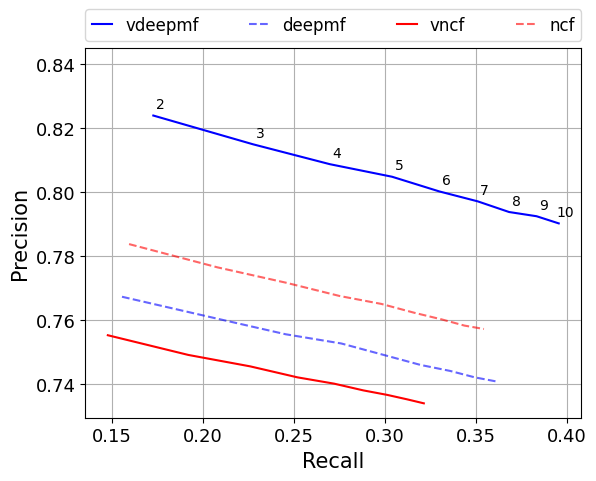

In [ ]:
for m in methods:
    c = 'blue' if 'deepmf' in m else 'red'
    alpha = 1 if m[0] == 'v' else 0.6
    ls = '-' if m[0] == 'v' else '--'

    plt.plot(recall[m], precision[m], c=c, ls=ls, alpha=alpha, label=m)

    if m == 'vdeepmf':
        for i,(r,p) in enumerate(zip(recall[m], precision[m])):
            plt.annotate(num_recommendations[i], (r,p), textcoords="offset points", xytext=(5,5), ha='center')

plt.xlabel('Recall', fontsize=15);
plt.ylabel('Precision', fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), fontsize=12, loc="lower left", mode="expand", borderaxespad=0, ncol=len(methods), handlelength=1.2)

plt.grid(True)

ylim_min, ylim_max = plt.ylim()
plt.ylim((ylim_min, ylim_max * 1.02))

plt.savefig('precision-recall.png', dpi=300)

plt.show()

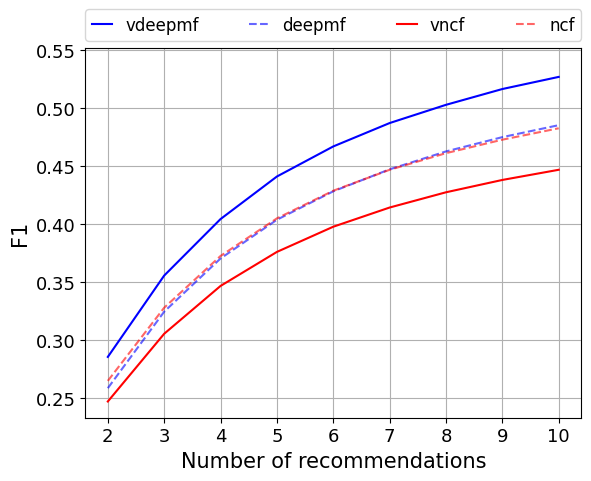

In [ ]:
for m in methods:
    c = 'blue' if 'deepmf' in m else 'red'
    alpha = 1 if m[0] == 'v' else 0.6
    ls = '-' if m[0] == 'v' else '--'

    plt.plot(num_recommendations, f1[m], c=c, ls=ls, alpha=alpha, label=m)

plt.xlabel('Number of recommendations', fontsize=15);
plt.ylabel('F1', fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), fontsize=12, loc="lower left", mode="expand", borderaxespad=0, ncol=len(methods), handlelength=1.2)

plt.grid(True)

ylim_min, ylim_max = plt.ylim()
plt.ylim((ylim_min, ylim_max * 1.02))

plt.savefig('f1.png', dpi=300)

plt.show()

#### Novelty

In [ ]:
def recommender_novelty(recommendations, y_true, y_pred, num_recommendations):
    novelty = np.zeros(len(num_recommendations))
    count = np.zeros(len(num_recommendations))

    bincount = np.bincount(X_test[1])

    for user_id, indices in recommendations.items():
        for i, n in enumerate(num_recommendations):
            for index in indices[:n]:
                item_id = X_test[1][index]
                num_item_ratings = bincount[item_id]
                total_num_ratings = len(X_test[1])
                pi = num_item_ratings / total_num_ratings
                novelty[i] += -math.log(pi,2)
                count[i] += 1

    return novelty/count

vdeepmf
deepmf
vncf
ncf


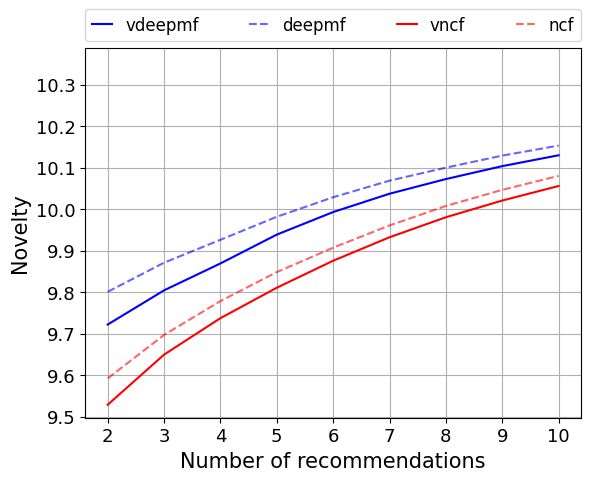

In [ ]:
for m in methods:
    print(m)

    y_pred = preds[m].to_numpy()
    novelty = recommender_novelty(recommendations[m], y_true, y_pred, num_recommendations)

    c = 'blue' if 'deepmf' in m else 'red'
    alpha = 1 if m[0] == 'v' else 0.6
    ls = '-' if m[0] == 'v' else '--'

    plt.plot(num_recommendations, novelty, c=c, ls=ls, alpha=alpha, label=m)

plt.xlabel('Number of recommendations', fontsize=15);
plt.ylabel('Novelty', fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), fontsize=12, loc="lower left", mode="expand", borderaxespad=0, ncol=len(methods), handlelength=1.2)

plt.grid(True)

ylim_min, ylim_max = plt.ylim()
plt.ylim((ylim_min, ylim_max * 1.02))

plt.savefig('novelty.png', dpi=300)

plt.show()

#### NDCG

In [ ]:
def recommender_ndcg(recommendations, y_true, y_pred, N):
    ndcg = 0
    count = 0

    for indices in recommendations.values():
        if len(indices) > 1:
            user_true = np.array([y_true[i] for i in indices])
            user_pred = np.array([y_pred[i] for i in indices])

            user_true = np.expand_dims(user_true, axis=0)
            user_pred = np.expand_dims(user_pred, axis=0)

            ndcg += ndcg_score(user_true, user_pred, k=N, ignore_ties=False)
            count += 1

    return ndcg / count

vdeepmf
deepmf
vncf
ncf


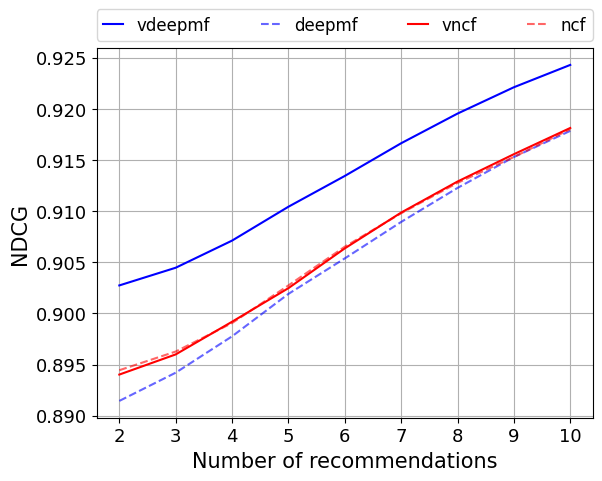

In [ ]:
for m in methods:
    print(m)

    ndcg = np.zeros(len(num_recommendations))

    for i, n in enumerate(num_recommendations):
        y_pred = preds[m].to_numpy()
        ndcg[i] = recommender_ndcg(recommendations[m], y_true, y_pred, n)

    c = 'blue' if 'deepmf' in m else 'red'
    alpha = 1 if m[0] == 'v' else 0.6
    ls = '-' if m[0] == 'v' else '--'

    plt.plot(num_recommendations, ndcg, c=c, ls=ls, alpha=alpha, label=m)

plt.xlabel('Number of recommendations', fontsize=15);
plt.ylabel('NDCG', fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), fontsize=12, loc="lower left", mode="expand", borderaxespad=0, ncol=len(methods), handlelength=1.2)

plt.grid(True)

plt.savefig('ndcg.png', dpi=300)

plt.show()